# Whale Detection Challenge : final_NN_model

Method overview : FFT to convert the sound tracks into spectrograms, and apply distinct preprocessing methods such as clipping, noise removal, PCEN and filters. After preprocessing we feed the spectrograms into state of the art light CNN models such as Resnet 18, VGG 16 or GoogleNet to identify right whale call patterns and perform classification. We may also try the removal of pooling layers in the networks and see if it causes better outcome.

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import cv2
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.3.1
Torchvision Version:  0.4.2


## Import and Load Data

In [2]:
num_classes = 2
batch_size = 32
num_epochs = 100
feature_extract = True
groups = 3
vis_batch = 4
r=0.05 #loss = class_loss + r*recover_loss

In [3]:
data_dir = "data/"
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x+"_prep_10/"), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=8) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


## Model

In [4]:
# The nn CNN model
class nn_model(nn.Module):
    # input size 40*500
    # image = cv2.resize(image, (40, 500), interpolation = cv2.INTER_CUBIC)

    def __init__(self):
        super(nn_model, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7, stride=1, padding=(3, 3), bias=False),
            nn.BatchNorm2d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=7, stride=1, padding=(3, 3), bias=False),
            nn.BatchNorm2d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=7, stride=1, padding=(3, 3), bias=False),
            nn.BatchNorm2d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=(2, 2), bias=False),
            nn.BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=5, stride=1, padding=(2, 2), bias=False),
            nn.BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=5, stride=1, padding=(2, 2), bias=False),
            nn.BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=(1, 1), bias=False),
            nn.BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=(1, 1), bias=False),
            nn.BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=(1, 1), bias=False),
            nn.BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
        )    
        self.decoder = nn.Sequential(             
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=(1, 1), bias=False),
            nn.BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=(1, 1), bias=False),
            nn.BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=(1, 1), bias=False),
            nn.BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Dropout2d(p=0.3),
            nn.ConvTranspose2d(16, 16, kernel_size=5, stride=1, padding=(2, 2), bias=False),
            nn.BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 16, kernel_size=5, stride=1, padding=(2, 2), bias=False),
            nn.BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=5, stride=1, padding=(2, 2), bias=False),
            nn.BatchNorm2d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Dropout2d(p=0.3),
            nn.ConvTranspose2d(8, 8, kernel_size=7, stride=1, padding=(3, 3), bias=False),
            nn.BatchNorm2d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 8, kernel_size=7, stride=1, padding=(3, 3), bias=False),
            nn.BatchNorm2d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, kernel_size=7, stride=1, padding=(3, 3), bias=False),
            nn.BatchNorm2d(3, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest')
        )
        self.classifier = nn.Sequential(  
            nn.Flatten(),
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Linear(1024, 2),
            nn.BatchNorm1d(2, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
        )
    def forward(self, x):
        x_code = self.encoder(x)
        x_class = self.classifier(x_code)
        x_recover = self.decoder(x_code)      
        return x_class, x_recover #classification and recover vectors of 


In [5]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = nn_model()
#     num_ftrs = model_ft.fc3.out_features
#     model_ft.fc4 = nn.Linear(num_ftrs, num_classes)
    input_size = (64, 64)  
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

nn_model(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (4): BatchNorm2d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(8, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (7): BatchNorm2d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (10): Dropout2d(p=0.3, inplace=False)
    (11): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (12): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bia

## Training Section

### training fuction

In [6]:
def train_model(model, dataloaders, criterion_class, criterion_recover, r, optimizer, num_epochs=25):
    since = time.time()
    history = {'train_loss':[],'train_class_loss':[],'train_recover_loss':[],'train_acc':[],'val_loss':[],'val_class_loss':[],
                'val_recover_loss':[],'val_acc':[]}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0
            running_class_loss = 0
            running_recover_loss = 0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs_class, outputs_recover = model(inputs)
                    class_loss = criterion_class(outputs_class, labels)
                    # print(outputs_recover.shape)
                    # print(inputs.shape)
                    recover_loss = criterion_recover(outputs_recover, inputs)
                    loss = class_loss + r*recover_loss
                    _, preds = torch.max(outputs_class, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_class_loss += class_loss.item() * inputs.size(0)
                running_recover_loss += recover_loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_class_loss = running_class_loss / len(dataloaders[phase].dataset)
            epoch_recover_loss = running_recover_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_class_loss'].append(epoch_class_loss)
                history['train_recover_loss'].append(epoch_recover_loss)
                history['train_acc'].append(epoch_acc)
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                history['val_loss'].append(epoch_loss)
                history['val_class_loss'].append(epoch_class_loss)
                history['val_recover_loss'].append(epoch_recover_loss)
                history['val_acc'].append(epoch_acc)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history, best_acc

### optimizer

In [7]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 encoder.0.weight
	 encoder.1.weight
	 encoder.1.bias
	 encoder.3.weight
	 encoder.4.weight
	 encoder.4.bias
	 encoder.6.weight
	 encoder.7.weight
	 encoder.7.bias
	 encoder.11.weight
	 encoder.12.weight
	 encoder.12.bias
	 encoder.14.weight
	 encoder.15.weight
	 encoder.15.bias
	 encoder.17.weight
	 encoder.18.weight
	 encoder.18.bias
	 encoder.22.weight
	 encoder.23.weight
	 encoder.23.bias
	 encoder.25.weight
	 encoder.26.weight
	 encoder.26.bias
	 encoder.28.weight
	 encoder.29.weight
	 encoder.29.bias
	 decoder.0.weight
	 decoder.1.weight
	 decoder.1.bias
	 decoder.3.weight
	 decoder.4.weight
	 decoder.4.bias
	 decoder.6.weight
	 decoder.7.weight
	 decoder.7.bias
	 decoder.11.weight
	 decoder.12.weight
	 decoder.12.bias
	 decoder.14.weight
	 decoder.15.weight
	 decoder.15.bias
	 decoder.17.weight
	 decoder.18.weight
	 decoder.18.bias
	 decoder.22.weight
	 decoder.23.weight
	 decoder.23.bias
	 decoder.25.weight
	 decoder.26.weight
	 decoder.26.bias
	 decoder.28.we

### run and save model

In [8]:
# Setup the loss fxn
criterion_class = nn.CrossEntropyLoss()
criterion_recover = nn.MSELoss()
# Train and evaluate
model_ft, hist, best_acc = train_model(model_ft, dataloaders_dict, criterion_class, criterion_recover, r, optimizer_ft, num_epochs)
torch.save(model_ft.state_dict(), 'model_weight/NN_model_'+str(num_epochs))
print(model_ft.state_dict().keys())

Epoch 0/99
----------
train Loss: 0.7616 Acc: 0.6670
val Loss: 0.5635 Acc: 0.7793

Epoch 1/99
----------
train Loss: 0.6205 Acc: 0.7537
val Loss: 0.5688 Acc: 0.8163

Epoch 2/99
----------
train Loss: 0.5692 Acc: 0.8127
val Loss: 0.5025 Acc: 0.8407

Epoch 3/99
----------
train Loss: 0.5170 Acc: 0.8470
val Loss: 0.5051 Acc: 0.8470

Epoch 4/99
----------
train Loss: 0.4808 Acc: 0.8573
val Loss: 0.4419 Acc: 0.8773

Epoch 5/99
----------
train Loss: 0.4469 Acc: 0.8623
val Loss: 0.4279 Acc: 0.8820

Epoch 6/99
----------
train Loss: 0.4198 Acc: 0.8690
val Loss: 0.3816 Acc: 0.8913

Epoch 7/99
----------
train Loss: 0.4032 Acc: 0.8810
val Loss: 0.3825 Acc: 0.8903

Epoch 8/99
----------
train Loss: 0.3818 Acc: 0.8803
val Loss: 0.3701 Acc: 0.8887

Epoch 9/99
----------
train Loss: 0.3699 Acc: 0.8910
val Loss: 0.3596 Acc: 0.8957

Epoch 10/99
----------
train Loss: 0.3556 Acc: 0.8937
val Loss: 0.3564 Acc: 0.8847

Epoch 11/99
----------
train Loss: 0.3421 Acc: 0.8930
val Loss: 0.3386 Acc: 0.8930

Ep

train Loss: 0.0853 Acc: 0.9980
val Loss: 0.3602 Acc: 0.8940

Epoch 99/99
----------
train Loss: 0.0857 Acc: 0.9977
val Loss: 0.3581 Acc: 0.8900

Training complete in 8m 27s
Best val Acc: 0.910000
odict_keys(['encoder.0.weight', 'encoder.1.weight', 'encoder.1.bias', 'encoder.1.running_mean', 'encoder.1.running_var', 'encoder.1.num_batches_tracked', 'encoder.3.weight', 'encoder.4.weight', 'encoder.4.bias', 'encoder.4.running_mean', 'encoder.4.running_var', 'encoder.4.num_batches_tracked', 'encoder.6.weight', 'encoder.7.weight', 'encoder.7.bias', 'encoder.7.running_mean', 'encoder.7.running_var', 'encoder.7.num_batches_tracked', 'encoder.11.weight', 'encoder.12.weight', 'encoder.12.bias', 'encoder.12.running_mean', 'encoder.12.running_var', 'encoder.12.num_batches_tracked', 'encoder.14.weight', 'encoder.15.weight', 'encoder.15.bias', 'encoder.15.running_mean', 'encoder.15.running_var', 'encoder.15.num_batches_tracked', 'encoder.17.weight', 'encoder.18.weight', 'encoder.18.bias', 'encoder.

### plot loss and accuracy

dict_keys(['train_loss', 'train_class_loss', 'train_recover_loss', 'train_acc', 'val_loss', 'val_class_loss', 'val_recover_loss', 'val_acc'])


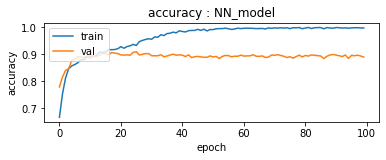

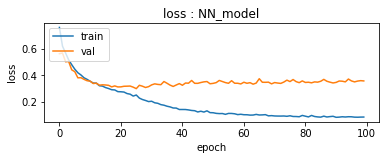

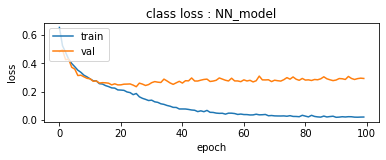

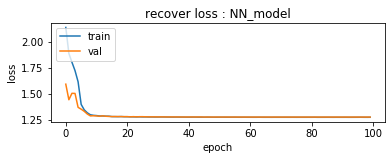

tensor(0.9100, device='cuda:0', dtype=torch.float64)


In [9]:
print(hist.keys())

#### Fill in plot #####
#Plot accuracy vs epoch
plt.subplot(211)

plt.plot(hist['train_acc'])
plt.plot(hist['val_acc'])
plt.title('accuracy : NN_model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Plot loss vs epoch
plt.subplot(212)
plt.plot(hist['train_loss'])
plt.plot(hist['val_loss'])
plt.title('loss : NN_model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Plot class loss vs epoch
plt.subplot(212)
plt.plot(hist['train_class_loss'])
plt.plot(hist['val_class_loss'])
plt.title('class loss : NN_model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Plot recover loss vs epoch
plt.subplot(212)
plt.plot(hist['train_recover_loss'])
plt.plot(hist['val_recover_loss'])
plt.title('recover loss : NN_model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

print(best_acc)

### load model and prediction

In [10]:
def forward_vis(vis_loader, groups):
    since = time.time()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model = nn_model()
    set_parameter_requires_grad(model, feature_extract)
    # load best model weights
    state_dict = torch.load('model_weight/NN_model_'+str(num_epochs))
    print(state_dict.keys())
    model.load_state_dict(torch.load('model_weight/NN_model_'+str(num_epochs)))
    model.to(device)
    model.eval()   # Set model to evaluate mode
    # Iterate over data.
    cnt=0
    vis_dict = {'inputs':np.empty([groups,vis_batch,3,64,64]),'outputs':np.empty([groups,vis_batch,num_classes]),'labels':np.empty([groups,vis_batch]),'preds':np.empty([groups,vis_batch])}
    for inputs, labels in vis_loader:
            if(cnt==groups):
                break;
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            vis_dict['inputs'][cnt,:,:,:,:]=inputs.cpu().numpy()
            vis_dict['labels'][cnt,:]=labels.cpu().numpy()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(False):
            # Get model outputs and calculate loss
            # Special case for inception because in training it has an auxiliary output. In train
            #   mode we calculate the loss by summing the final output and the auxiliary output
            #   but in testing we only consider the final output.
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                vis_dict['outputs'][cnt,:,:]=outputs.cpu().numpy()
                vis_dict['preds'][cnt,:]=preds.cpu().numpy()
            cnt+=1
            

    time_elapsed = time.time() - since
    print()
    print('Inference complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return vis_dict

vis_loader = torch.utils.data.DataLoader(image_datasets['val'], batch_size=vis_batch, shuffle=True, num_workers=8)
vis_dict = forward_vis(vis_loader, groups)
print(vis_dict['inputs'].shape)
print(vis_dict['outputs'].shape)
print(vis_dict['labels'].shape)
print(vis_dict['preds'].shape)

cuda:0
odict_keys(['encoder.0.weight', 'encoder.1.weight', 'encoder.1.bias', 'encoder.1.running_mean', 'encoder.1.running_var', 'encoder.1.num_batches_tracked', 'encoder.3.weight', 'encoder.4.weight', 'encoder.4.bias', 'encoder.4.running_mean', 'encoder.4.running_var', 'encoder.4.num_batches_tracked', 'encoder.6.weight', 'encoder.7.weight', 'encoder.7.bias', 'encoder.7.running_mean', 'encoder.7.running_var', 'encoder.7.num_batches_tracked', 'encoder.11.weight', 'encoder.12.weight', 'encoder.12.bias', 'encoder.12.running_mean', 'encoder.12.running_var', 'encoder.12.num_batches_tracked', 'encoder.14.weight', 'encoder.15.weight', 'encoder.15.bias', 'encoder.15.running_mean', 'encoder.15.running_var', 'encoder.15.num_batches_tracked', 'encoder.17.weight', 'encoder.18.weight', 'encoder.18.bias', 'encoder.18.running_mean', 'encoder.18.running_var', 'encoder.18.num_batches_tracked', 'encoder.22.weight', 'encoder.23.weight', 'encoder.23.bias', 'encoder.23.running_mean', 'encoder.23.running_var

TypeError: max() received an invalid combination of arguments - got (tuple, int), but expected one of:
 * (Tensor input)
 * (Tensor input, name dim, bool keepdim, tuple of Tensors out)
 * (Tensor input, Tensor other, Tensor out)
 * (Tensor input, int dim, bool keepdim, tuple of Tensors out)


### visualization 

In [ ]:
for i in range(groups) :
    for j in range(vis_batch) :
        plt.figure(figsize=(15,15))
        plt.subplot(groups,vis_batch,4*i+j+1)
        image = np.moveaxis(np.squeeze(vis_dict['inputs'][i,j]), 0, -1)
        image = (image-np.amin(image))/(np.amax(image)-np.amin(image))
        plt.imshow(image)
        plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        left=False,         # ticks along the left edge are off
        labelbottom=False,
        labelleft=False) # labels along the bottom edge are off
        plt.title('preprocessed '+str(i)+' '+str(j))
        plt.xlabel('label : '+str(vis_dict['labels'][i,j])+', pred : '+str(vis_dict['preds'][i,j])+', output : '+str(vis_dict['outputs'][i,j,:]))
plt.show()